<a href="https://colab.research.google.com/github/6poh66/FraudDetectionBlockchain/blob/main/Fraud_Detection_FInal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip -q install --upgrade pip
!pip -q install \
  numpy==2.0.2 \
  scipy==1.13.1 \
  pandas==2.2.2 \
  scikit-learn==1.5.1 \
  imbalanced-learn==0.12.3 \
  shap==0.46.0 \
  xgboost==2.1.0 \
  lightgbm==4.5.0 \
  matplotlib==3.8.4
!pip install -q kaggle
!pip install lightgbm


In [2]:
from google.colab import files

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Dataset Download from Kaggle
!kaggle datasets download -d mlg-ulb/creditcardfraud

!unzip -q creditcardfraud.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.19GB/s]


# **INSTALLING DEPENDENCIES**

In [3]:
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score,
    recall_score, f1_score, accuracy_score
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier as CART
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

import shap
shap.initjs()


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# KS statistic
def ks_statistic(y_true, y_score):


    order = np.argsort(y_score)
    y_true_sorted = np.array(y_true)[order]


    cum_pos = np.cumsum(y_true_sorted) / (y_true_sorted.sum() if y_true_sorted.sum() > 0 else 1)
    cum_neg = np.cumsum(1 - y_true_sorted) / ((len(y_true_sorted) - y_true_sorted.sum()) if (len(y_true_sorted) - y_true_sorted.sum()) > 0 else 1)
    ks = np.max(np.abs(cum_pos - cum_neg))
    return ks

# Metrics
def compute_metrics(y_true, y_proba, threshold=0.5):
    y_hat = (y_proba >= threshold).astype(int)
    return {
        "KS": ks_statistic(y_true, y_proba),
        "AUC": roc_auc_score(y_true, y_proba),
        "F1-Score": f1_score(y_true, y_hat, zero_division=0),
        "Recall": recall_score(y_true, y_hat, zero_division=0),
        "PRAUC": average_precision_score(y_true, y_proba),
        "Precision": precision_score(y_true, y_hat, zero_division=0),
        "Accuracy": accuracy_score(y_true, y_hat)
    }


# **Load The Dataset**

In [4]:

df = pd.read_csv("creditcard.csv")
print(df.shape)
df.head()


(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Remove Ultra-Correlated Duplicates

In [5]:
TARGET = "Class"

features = [c for c in df.columns if c != TARGET]
corr = df[features].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]
print("Dropping due to |r|>=0.99:", to_drop)

df_model = df.drop(columns=to_drop)


Dropping due to |r|>=0.99: []


# **Random Forest Feature Selection**

In [6]:
X_all = df_model.drop(columns=[TARGET])
y_all = df_model[TARGET].values

rf_for_importance = RandomForestClassifier(
    n_estimators=500, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced"
)
rf_for_importance.fit(X_all, y_all)
imp = pd.Series(rf_for_importance.feature_importances_, index=X_all.columns).sort_values(ascending=False)
top_27 = imp.head(27).index.tolist()
top_27


['V14',
 'V10',
 'V4',
 'V12',
 'V17',
 'V11',
 'V3',
 'V16',
 'V7',
 'V2',
 'V21',
 'V9',
 'V19',
 'Amount',
 'V18',
 'V5',
 'V20',
 'V8',
 'V27',
 'V6',
 'V13',
 'V1',
 'V26',
 'V28',
 'V15',
 'V23',
 'V22']

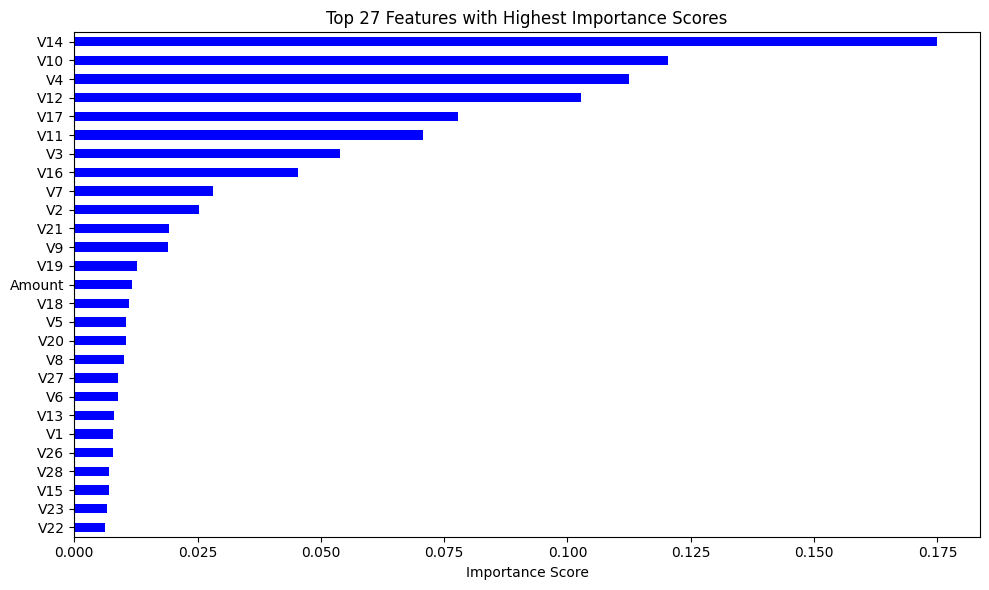

In [7]:
#Plotting
top_27_imp = imp.head(27)

plt.figure(figsize=(10,6))
top_27_imp[::-1].plot(kind='barh', color='blue')  # reverse order for top-to-bottom
plt.title("Top 27 Features with Highest Importance Scores")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

In [8]:
X = df_model[top_27].copy()
y = df_model[TARGET].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

# Scaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

print("Train size:", X_train.shape, "Positives:", y_train.sum(), "Negatives:", (y_train==0).sum())
print("Test size :", X_test.shape,  "Positives:", y_test.sum(),  "Negatives:", (y_test==0).sum())


Train size: (199364, 27) Positives: 344 Negatives: 199020
Test size : (85443, 27) Positives: 148 Negatives: 85295


# **SMOTE**

In [9]:
smote = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)
X_train_bal, y_train_bal = smote.fit_resample(X_train_s, y_train)

#Check
unique, counts = np.unique(y_train_bal, return_counts=True)
dict(zip(unique, counts))


{np.int64(0): np.int64(199020), np.int64(1): np.int64(199020)}

# **Models**

In [10]:
models = {
    "LR":  LogisticRegression(max_iter=2000, n_jobs=-1, random_state=RANDOM_STATE),
    "LDA": LDA(),
    #"KNN": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "CART": CART(random_state=RANDOM_STATE),
    "NB": GaussianNB(),
    #"SVM": SVC(probability=True, kernel="rbf", C=1.0, gamma="scale", random_state=RANDOM_STATE),
    "RF":  RandomForestClassifier(n_estimators=600, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(
        n_estimators=600, max_depth=6, learning_rate=0.1,
        subsample=1.0, colsample_bytree=1.0, n_jobs=-1,
        eval_metric="logloss", random_state=RANDOM_STATE
    ),
    "Light GBM": LGBMClassifier(
        n_estimators=600, learning_rate=0.1, subsample=1.0,
        colsample_bytree=1.0, n_jobs=-1, random_state=RANDOM_STATE
    ),
}


# **Train on Balanced Train**

In [11]:
train_rows = []
trained = {}

for name, model in models.items():
    model.fit(X_train_bal, y_train_bal)
    trained[name] = model

    # Probabilities
    if hasattr(model, "predict_proba"):
        proba_train = model.predict_proba(X_train_bal)[:, 1]
    else:
        # Fallback for models w/out predict_proba
        proba_train = model.decision_function(X_train_bal)
        proba_train = (proba_train - proba_train.min()) / (proba_train.max() - proba_train.min() + 1e-12)

    m = compute_metrics(y_train_bal, proba_train, threshold=0.5)
    m["Model"] = name
    train_rows.append(m)

train_df = pd.DataFrame(train_rows)[["Model","KS","AUC","F1-Score","Recall","PRAUC","Precision","Accuracy"]]
train_df.sort_values("AUC", ascending=False).reset_index(drop=True)


[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.042151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


,Model,KS,AUC,F1-Score,Recall,PRAUC,Precision,Accuracy
0,CART,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,XGB,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,RF,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Light GBM,0.996166,0.998377,0.998083,0.998231,0.997629,0.997935,0.998083
4,LR,0.922998,0.993039,0.956531,0.936931,0.993775,0.976968,0.957421
5,LDA,0.871932,0.982342,0.919945,0.862351,0.983421,0.985784,0.924957
6,NB,0.843820,0.951760,0.917342,0.867229,0.957794,0.973600,0.921857


Evaluate on Test (Check for Overfitting)

In [12]:
test_rows = []

for name, model in trained.items():
    if hasattr(model, "predict_proba"):
        proba_test = model.predict_proba(X_test_s)[:, 1]
    else:
        proba_raw = model.decision_function(X_test_s)
        proba_test = (proba_raw - proba_raw.min()) / (proba_raw.max() - proba_raw.min() + 1e-12)

    m = compute_metrics(y_test, proba_test, threshold=0.5)
    m["Model"] = name
    test_rows.append(m)

test_df = pd.DataFrame(test_rows)[["Model","KS","AUC","F1-Score","Recall","PRAUC","Precision","Accuracy"]]
test_df.sort_values("AUC", ascending=False).reset_index(drop=True)


,Model,KS,AUC,F1-Score,Recall,PRAUC,Precision,Accuracy
0,RF,0.888515,0.977151,0.812500,0.790541,0.828074,0.835714,0.999368
1,XGB,0.866294,0.971855,0.805369,0.810811,0.834385,0.800000,0.999321
2,LR,0.861280,0.967754,0.115916,0.878378,0.708304,0.062053,0.976792
3,LDA,0.828262,0.959433,0.179845,0.783784,0.316479,0.101576,0.987617
4,NB,0.812596,0.954915,0.106817,0.831081,0.083838,0.057077,0.975925
5,Light GBM,0.821065,0.921237,0.442413,0.817568,0.290634,0.303258,0.996430
6,CART,0.707142,0.850220,0.467416,0.702703,0.246579,0.350168,0.997226


In [13]:
final_model = trained["RF"]

proba_test = final_model.predict_proba(X_test_s)[:, 1]
score = np.round(proba_test, 2) * 100

test_pred_df = pd.DataFrame({
    "proba": proba_test,
    "score": score.astype(int),
    "y": y_test
})
test_pred_df.head()


,proba,score,y
0,0.000000,0,0
1,0.000000,0,0
2,0.005000,0,0
3,0.000000,0,0
4,0.001667,0,0


10 Bin Detection Table

In [14]:
# Score bins
bin_edges = list(range(0, 101, 10))  # 0,10,20,...,100
bin_labels = [f"{a} - {b-1}" for a, b in zip(bin_edges[:-1], bin_edges[1:])]  # "0 - 9", ..., "90 - 99"


bin_edges_inclusive = bin_edges + [101]

test_pred_df["score_bin"] = pd.cut(
    test_pred_df["score"],
    bins=bin_edges_inclusive,
    right=False,
    labels=[f"{a} - {b-1}" for a, b in zip(bin_edges_inclusive[:-1], bin_edges_inclusive[1:])]
)

# Probability bins
prob_edges = [i/10 for i in range(11)] + [1.01]
test_pred_df["prob_bin"] = pd.cut(
    test_pred_df["proba"],
    bins=prob_edges,
    right=False,
    labels=[f"[{a:.1f} - {b:.1f})" for a, b in zip(prob_edges[:-2], prob_edges[1:-1])] + ["[1.0 - 1.0]"]
)


tot_fraud = (test_pred_df["y"]==1).sum()
tot_nonfraud = (test_pred_df["y"]==0).sum()

tab = (
    test_pred_df
      .groupby("score_bin")
      .apply(lambda g: pd.Series({
          "Score": g.name,
          "Probabilities": g["prob_bin"].value_counts().sort_index().index[-1] if len(g)>0 else "",
          "Non Fraud": (g["y"]==0).sum(),
          "Fraud": (g["y"]==1).sum(),
          "Total Transaction": len(g),
          "Fraud Rate": (g["y"].mean() if len(g) else 0.0)
      }))
      .reset_index(drop=True)
)

# score bin descending (risk high→low)
def bin_start(b): return int(str(b).split(" - ")[0])
tab = tab.sort_values(by="Score", key=lambda s: s.map(bin_start), ascending=False).reset_index(drop=True)

# Cumulative & rates
tab["Cum Non Fraud"] = tab["Non Fraud"].cumsum()
tab["Cum Fraud"] = tab["Fraud"].cumsum()
tab["Det Rate"] = tab["Cum Fraud"] / tot_fraud
tab["FPR"] = tab["Cum Non Fraud"] / tot_nonfraud

# Fromat
tab["Fraud Rate"] = (tab["Fraud Rate"]*100).round(2).astype(str) + "%"
tab["Det Rate"]   = (tab["Det Rate"]*100).round(2).astype(str) + "%"
tab["FPR"]        = (tab["FPR"]*100).round(2).astype(str) + "%"

tab


,Score,Probabilities,Non Fraud,Fraud,Total Transaction,Fraud Rate,Cum Non Fraud,Cum Fraud,Det Rate,FPR
0,100 - 100,[1.0 - 1.0],0,44,44,100.0%,0,44,29.73%,0.0%
1,90 - 99,[1.0 - 1.0],3,47,50,94.0%,3,91,61.49%,0.0%
2,80 - 89,[1.0 - 1.0],2,14,16,87.5%,5,105,70.95%,0.01%
3,70 - 79,[1.0 - 1.0],2,4,6,66.67%,7,109,73.65%,0.01%
4,60 - 69,[1.0 - 1.0],7,3,10,30.0%,14,112,75.68%,0.02%
5,50 - 59,[1.0 - 1.0],10,6,16,37.5%,24,118,79.73%,0.03%
6,40 - 49,[1.0 - 1.0],8,1,9,11.11%,32,119,80.41%,0.04%
7,30 - 39,[1.0 - 1.0],17,5,22,22.73%,49,124,83.78%,0.06%
8,20 - 29,[1.0 - 1.0],39,1,40,2.5%,88,125,84.46%,0.1%
9,10 - 19,[1.0 - 1.0],201,1,202,0.5%,289,126,85.14%,0.34%


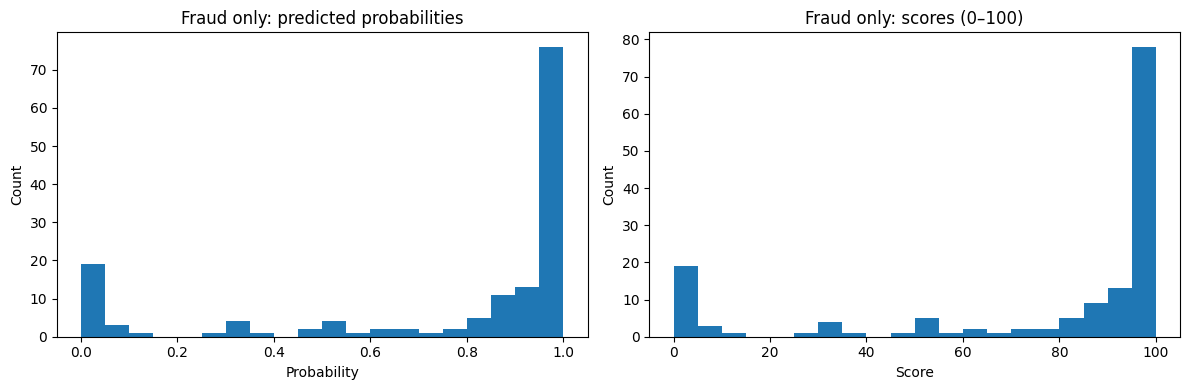

In [15]:
#Histogram
fraud_mask = (test_pred_df["y"]==1)
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].hist(test_pred_df.loc[fraud_mask,"proba"], bins=20)
ax[0].set_title("Fraud only: predicted probabilities")
ax[0].set_xlabel("Probability"); ax[0].set_ylabel("Count")

ax[1].hist(test_pred_df.loc[fraud_mask,"score"], bins=range(0,101,5))
ax[1].set_title("Fraud only: scores (0–100)")
ax[1].set_xlabel("Score"); ax[1].set_ylabel("Count")
plt.tight_layout()
plt.show()


rank ordering / monotonicity of fraud rate by score b

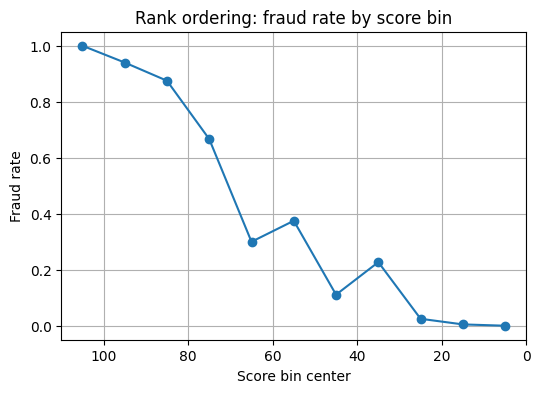

In [16]:
# Marginal FRaud Rate per bin
bin_centers = [int(s.split(" - ")[0]) + 5 for s in tab["Score"]]
fraud_rate_numbers = (
    test_pred_df.groupby("score_bin")["y"].mean()
    .reindex(tab["Score"])
    .fillna(0).values
)

plt.figure(figsize=(6,4))
plt.plot(bin_centers, fraud_rate_numbers, marker="o")
plt.gca().invert_xaxis()
plt.title("Rank ordering: fraud rate by score bin")
plt.xlabel("Score bin center"); plt.ylabel("Fraud rate")
plt.grid(True)
plt.show()


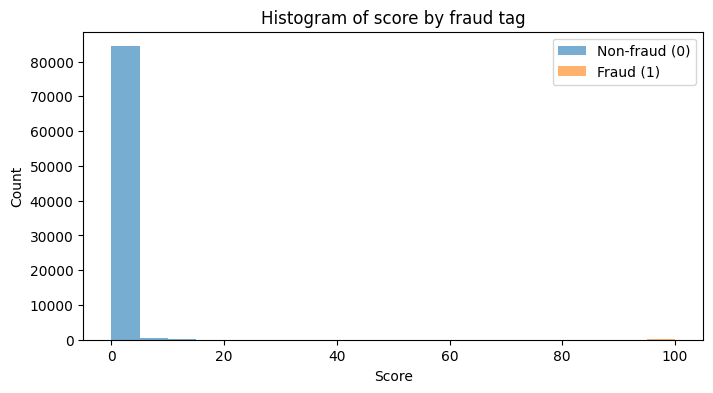

In [17]:
# histogram of score by fraud tag
plt.figure(figsize=(8,4))
plt.hist(test_pred_df.loc[test_pred_df["y"]==0, "score"], bins=range(0,101,5), alpha=0.6, label="Non-fraud (0)")
plt.hist(test_pred_df.loc[test_pred_df["y"]==1, "score"], bins=range(0,101,5), alpha=0.6, label="Fraud (1)")
plt.title("Histogram of score by fraud tag")
plt.xlabel("Score"); plt.ylabel("Count")
plt.legend()
plt.show()


# **SAving the Model**

In [18]:
import pickle
from sklearn.preprocessing import StandardScaler

with open("random_forest_model.pkl", "wb") as f:
    pickle.dump(trained["RF"], f)

print("✅ Model saved as 'random_forest_model.pkl'")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

✅ Model saved as 'random_forest_model.pkl'


100%|===================| 19998/20000 [50:15<00:00]       

SHAP Summary Plot (Multi-Class):


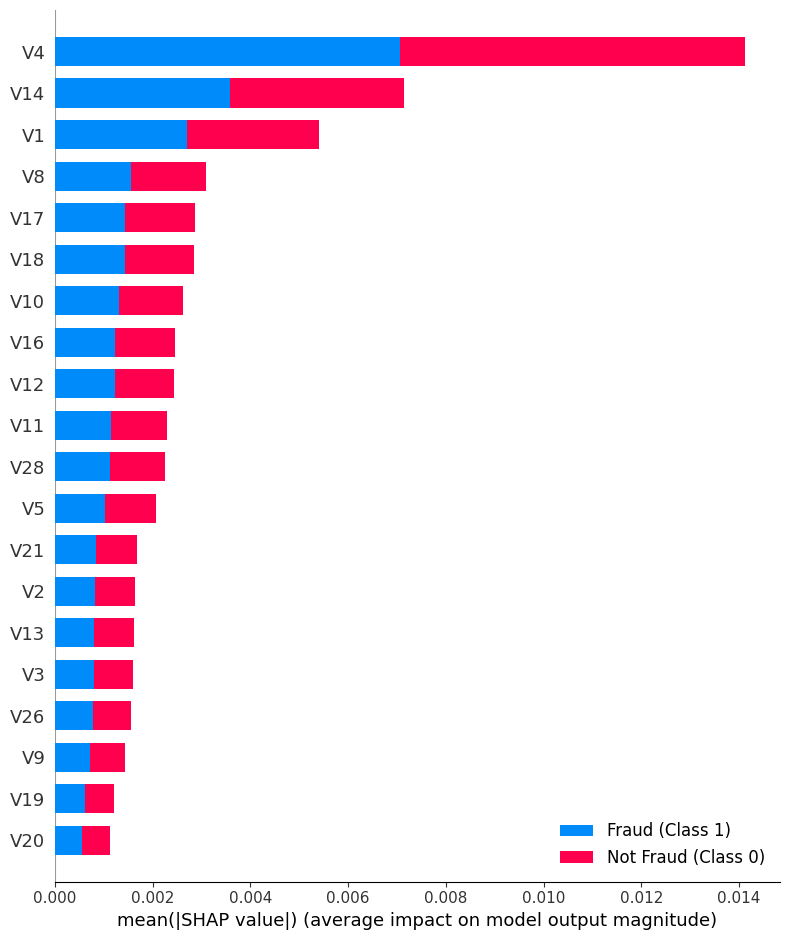


SHAP Force Plot for instance 15:


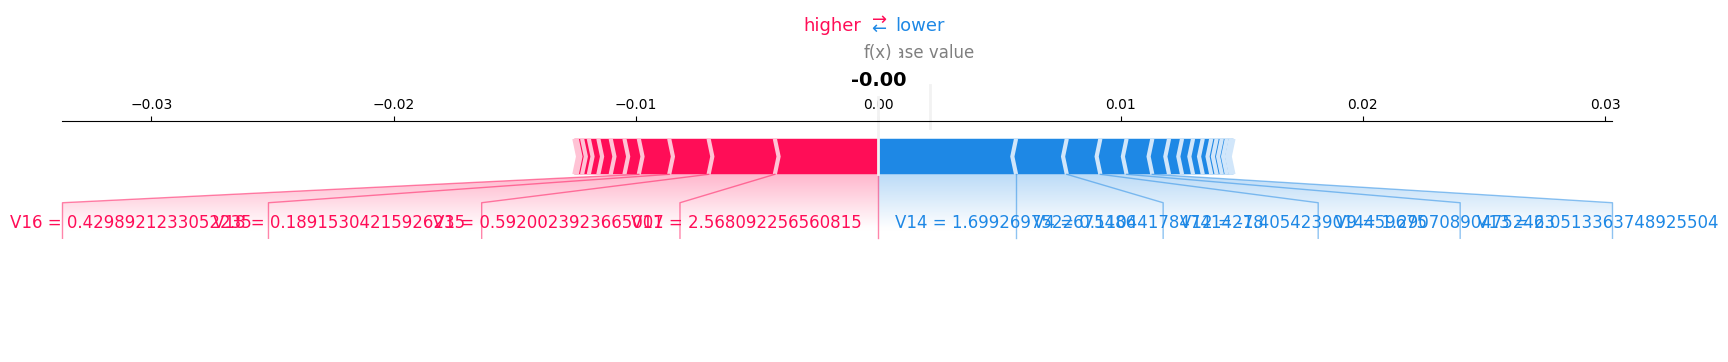


SHAP Force Plot for instance 20:


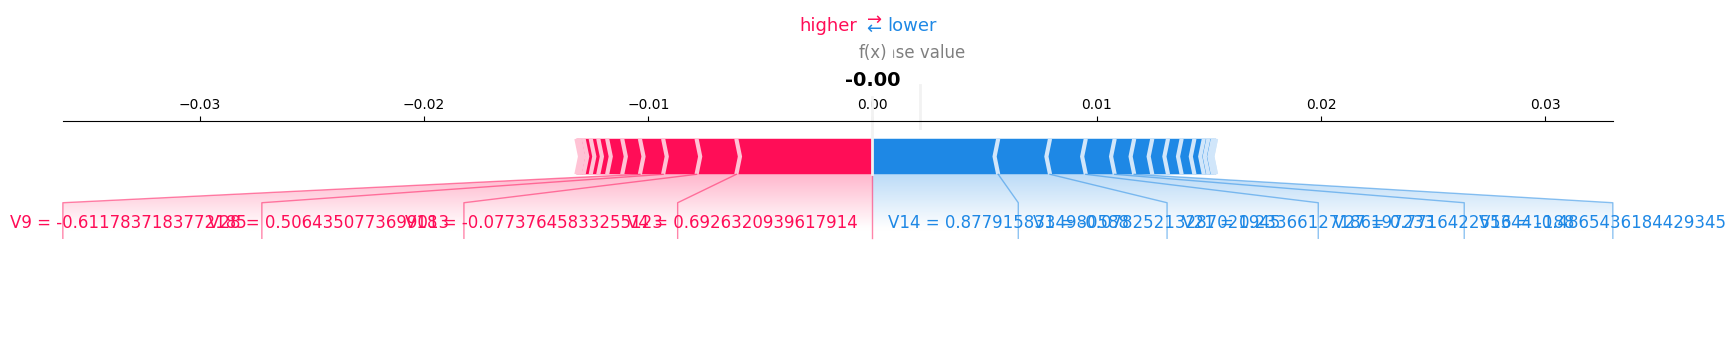


SHAP Force Plot for instance 40:


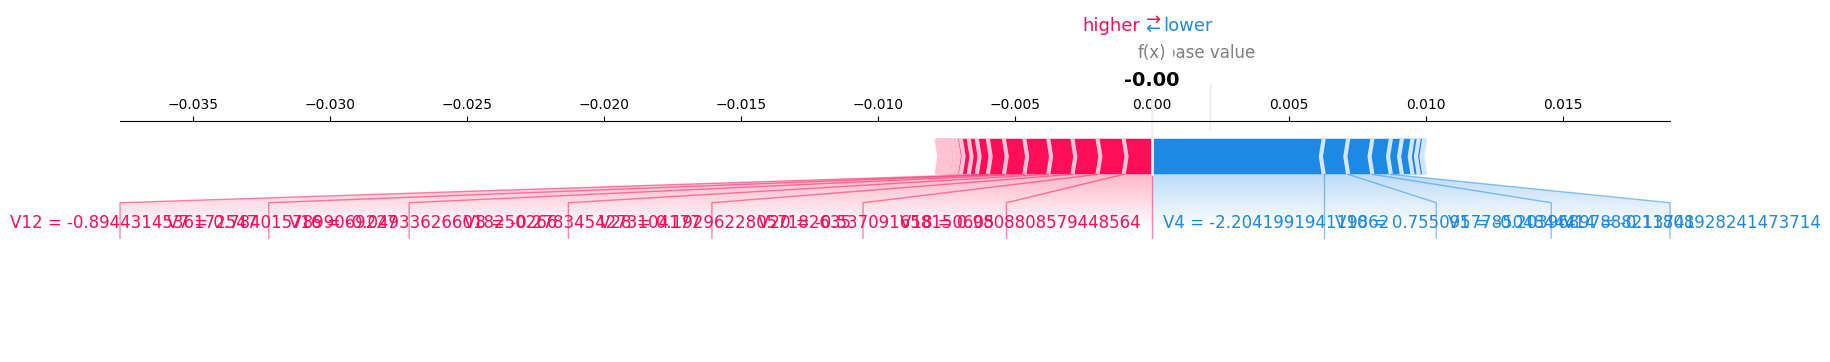

In [19]:

import shap
import pandas as pd

# Javascript
shap.initjs()

# Smaller Sample
X_test_s_df = pd.DataFrame(X_test_s, columns=X_test.columns)
X_test_s_sample_df = X_test_s_df.sample(10000, random_state=42)


explainer = shap.Explainer(final_model, X_test_s_sample_df)     #took help from ai model as was having problem with setting up explainer model with numpy

# Shap Values for Sample
shap_values_sample = explainer(X_test_s_sample_df)

shap_values_list = [shap_values_sample.values[:,:,1], shap_values_sample.values[:,:,0]]

print("SHAP Summary Plot (Multi-Class):")

shap.summary_plot(
    shap_values_list,
    X_test_s_sample_df,
    plot_type="bar",
    class_names=["Fraud (Class 1)", "Not Fraud (Class 0)"]
)



#FORCE Plots for isntances specific
print("\nSHAP Force Plot for instance 15:")
shap.force_plot(shap_values_sample[15,:,1], matplotlib=True)

print("\nSHAP Force Plot for instance 20:")
shap.force_plot(shap_values_sample[20,:,1], matplotlib=True)

print("\nSHAP Force Plot for instance 40:")
shap.force_plot(shap_values_sample[40,:,1], matplotlib=True)

In [21]:
import pandas as pd

# Load your dataset
df = pd.read_csv("creditcard.csv")

# Get a sample fraud row (Class == 1)
fraud_row = df[df["Class"] == 1].iloc[0]  # Get the first fraud sample

# Drop columns 'Time' and 'Class', keep only the 27 feature values
features = fraud_row.drop(["Time", "Class"]).tolist()

# Print it nicely to paste into curl
print(", ".join([str(round(f, 6)) for f in features]))


-2.312227, 1.951992, -1.609851, 3.997906, -0.522188, -1.426545, -2.537387, 1.391657, -2.770089, -2.772272, 3.202033, -2.899907, -0.595222, -4.289254, 0.389724, -1.140747, -2.830056, -0.016822, 0.416956, 0.126911, 0.517232, -0.035049, -0.465211, 0.320198, 0.044519, 0.17784, 0.261145, -0.143276, 0.0
